# Импорты

In [1]:
from pathlib import Path
from typing import Any

import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from mba.src import modeling, transforms, vis
from mba.src.const import TEST_DATA_PATH, TRAIN_DATA_PATH, TARGET
from mba.src.transforms import OneHotEncoder, PandasTransformer
from tqdm import tqdm
from typing import cast
import nltk


test_data = pd.read_csv(TEST_DATA_PATH)

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150
%load_ext autoreload
%autoreload 2

# Датасет

### Загрузить в pandas

In [2]:
loan_data = pd.read_csv(TRAIN_DATA_PATH)
print(loan_data.to_string())

      лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  бизнес         сумма                    сбор        срок  амортизация  только_процент  один_платеж  стоимость_имущества проживание тип_залога  тип_кредита  кредитный_рейтинг возраст  прямой_залог  дефолт                                                                                                                                                                                                                                                                                                                                                        речь
0               0.0    м  3.0   0.0                 1.0             NaN     0.0  1.747653e+05                  normal  245.885949          0.0             0.0          0.0         2.444881e+05        осн        дом          2.0         709.508335   55-64           1.0       0                                                                                                   

### Наличие аномалий

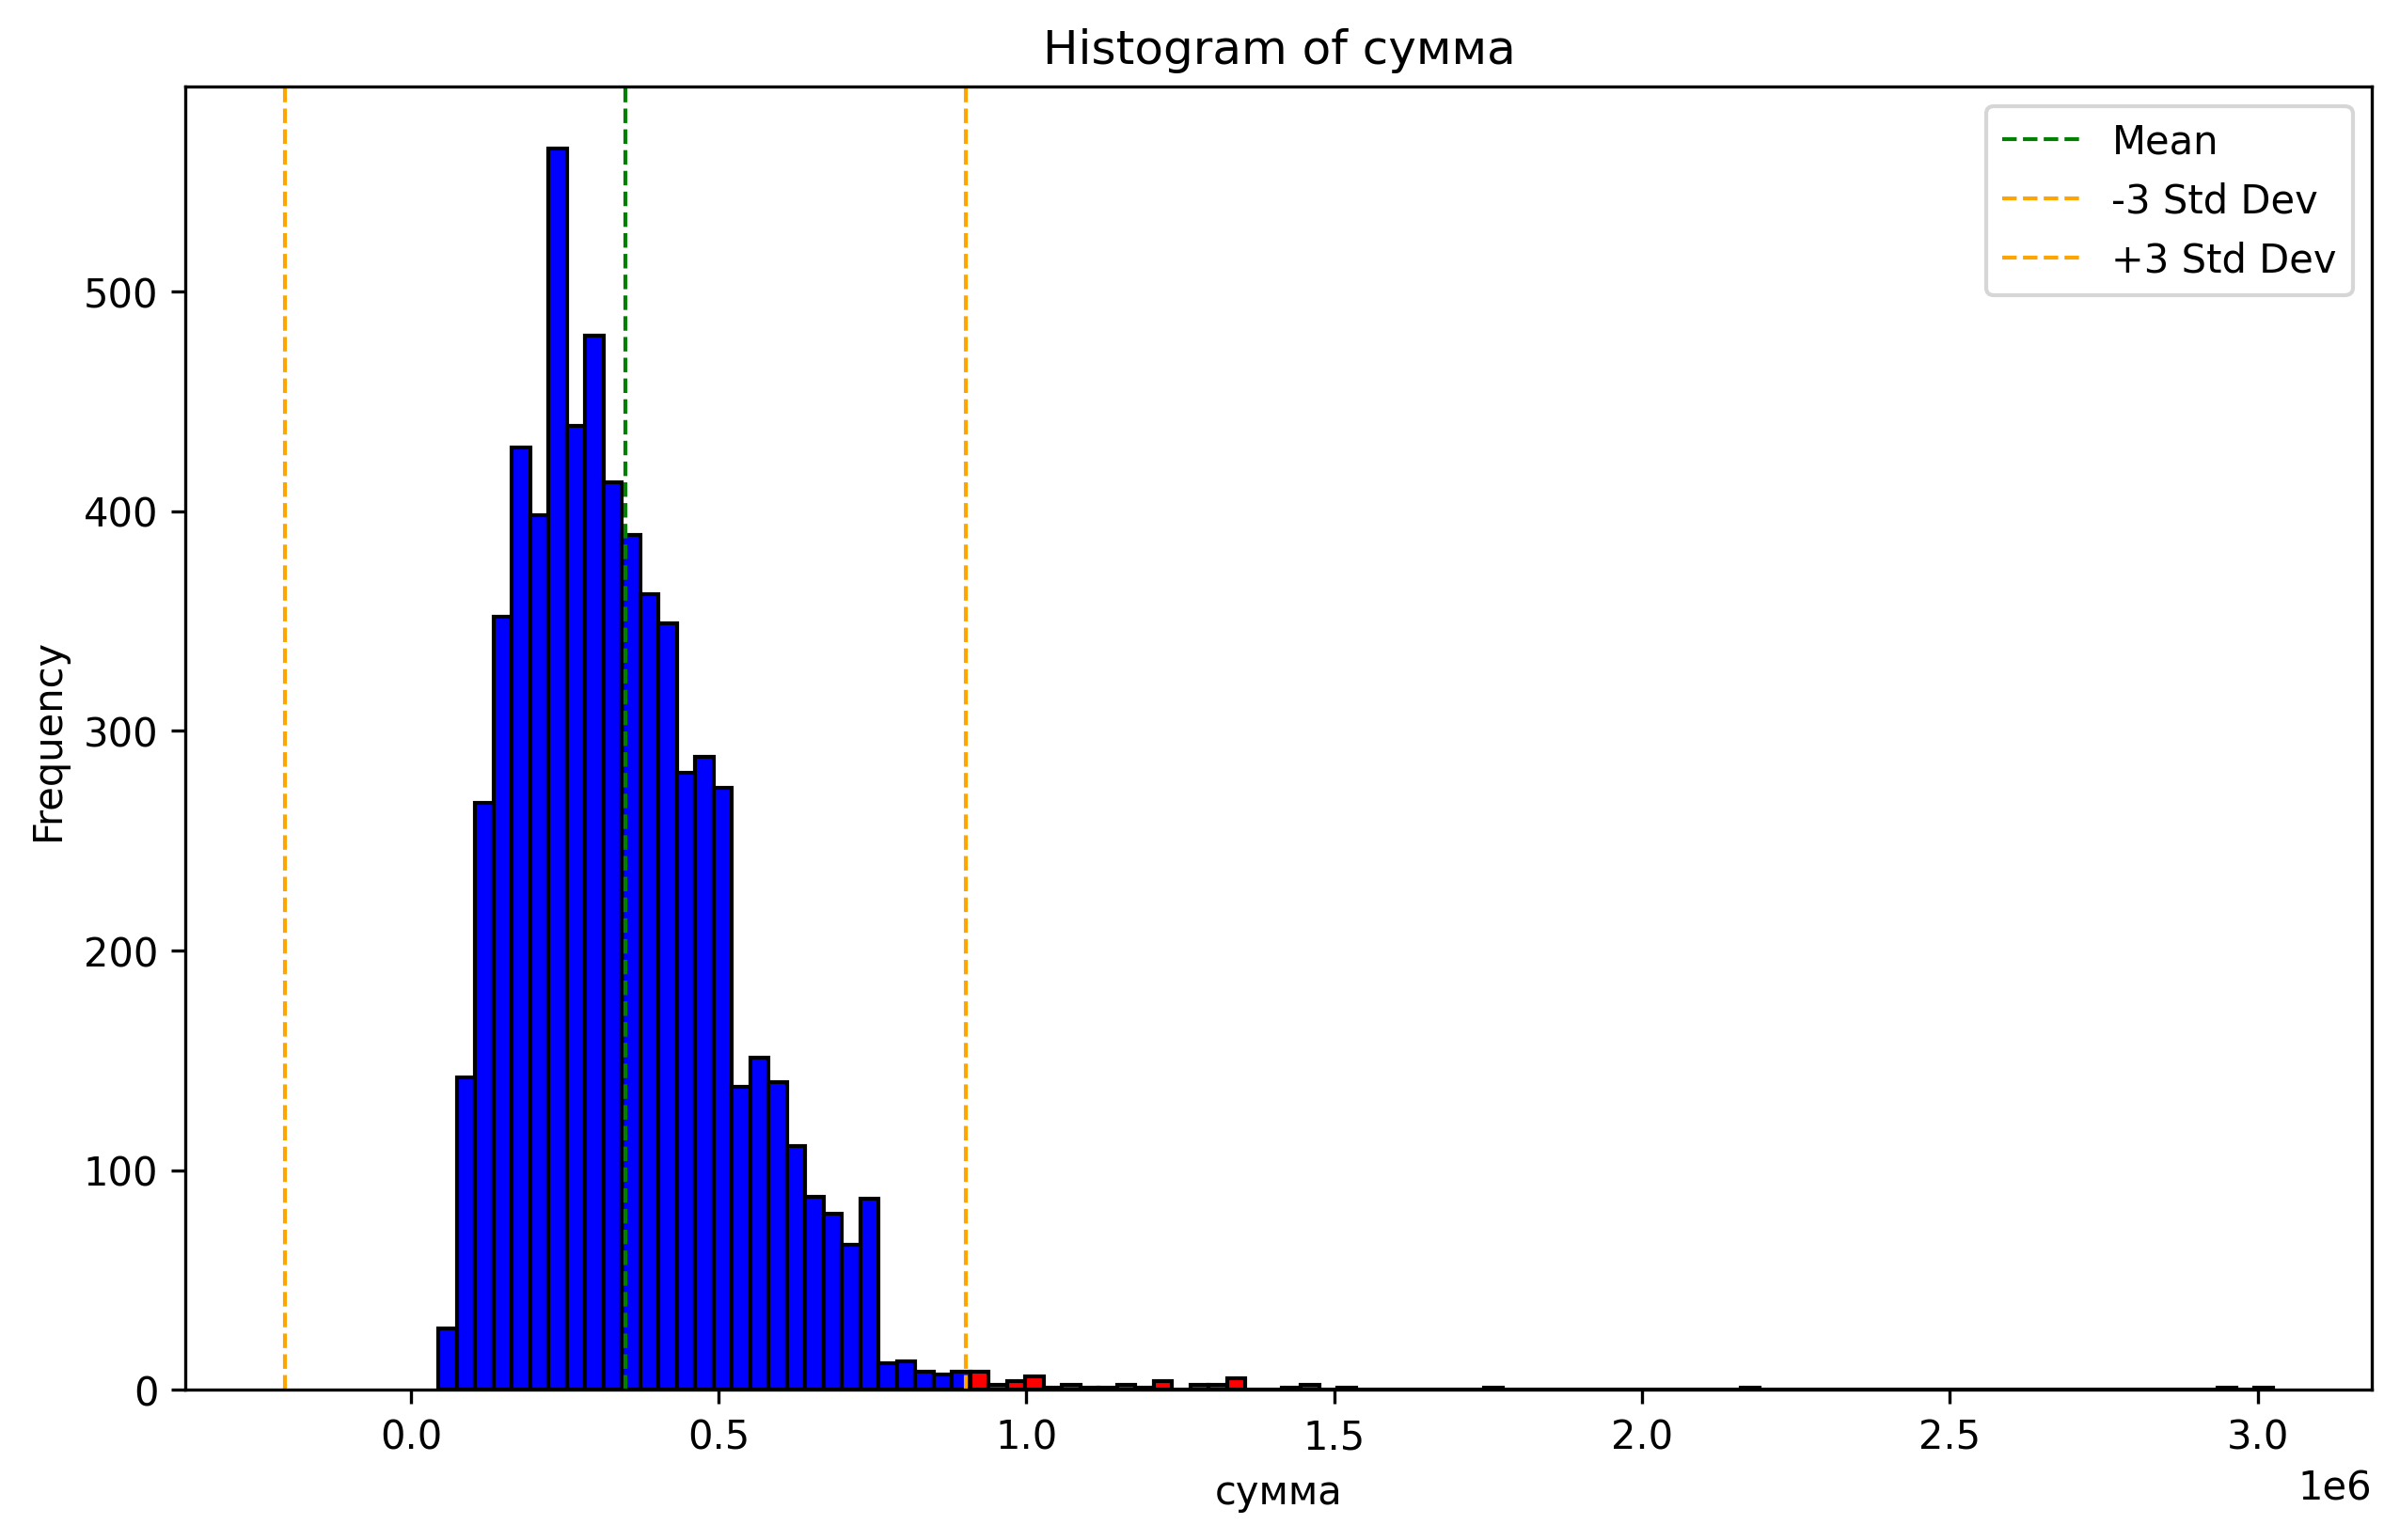

In [3]:
vis.plot_anomalies(loan_data, ["сумма"])

### Заменить аномальные значения

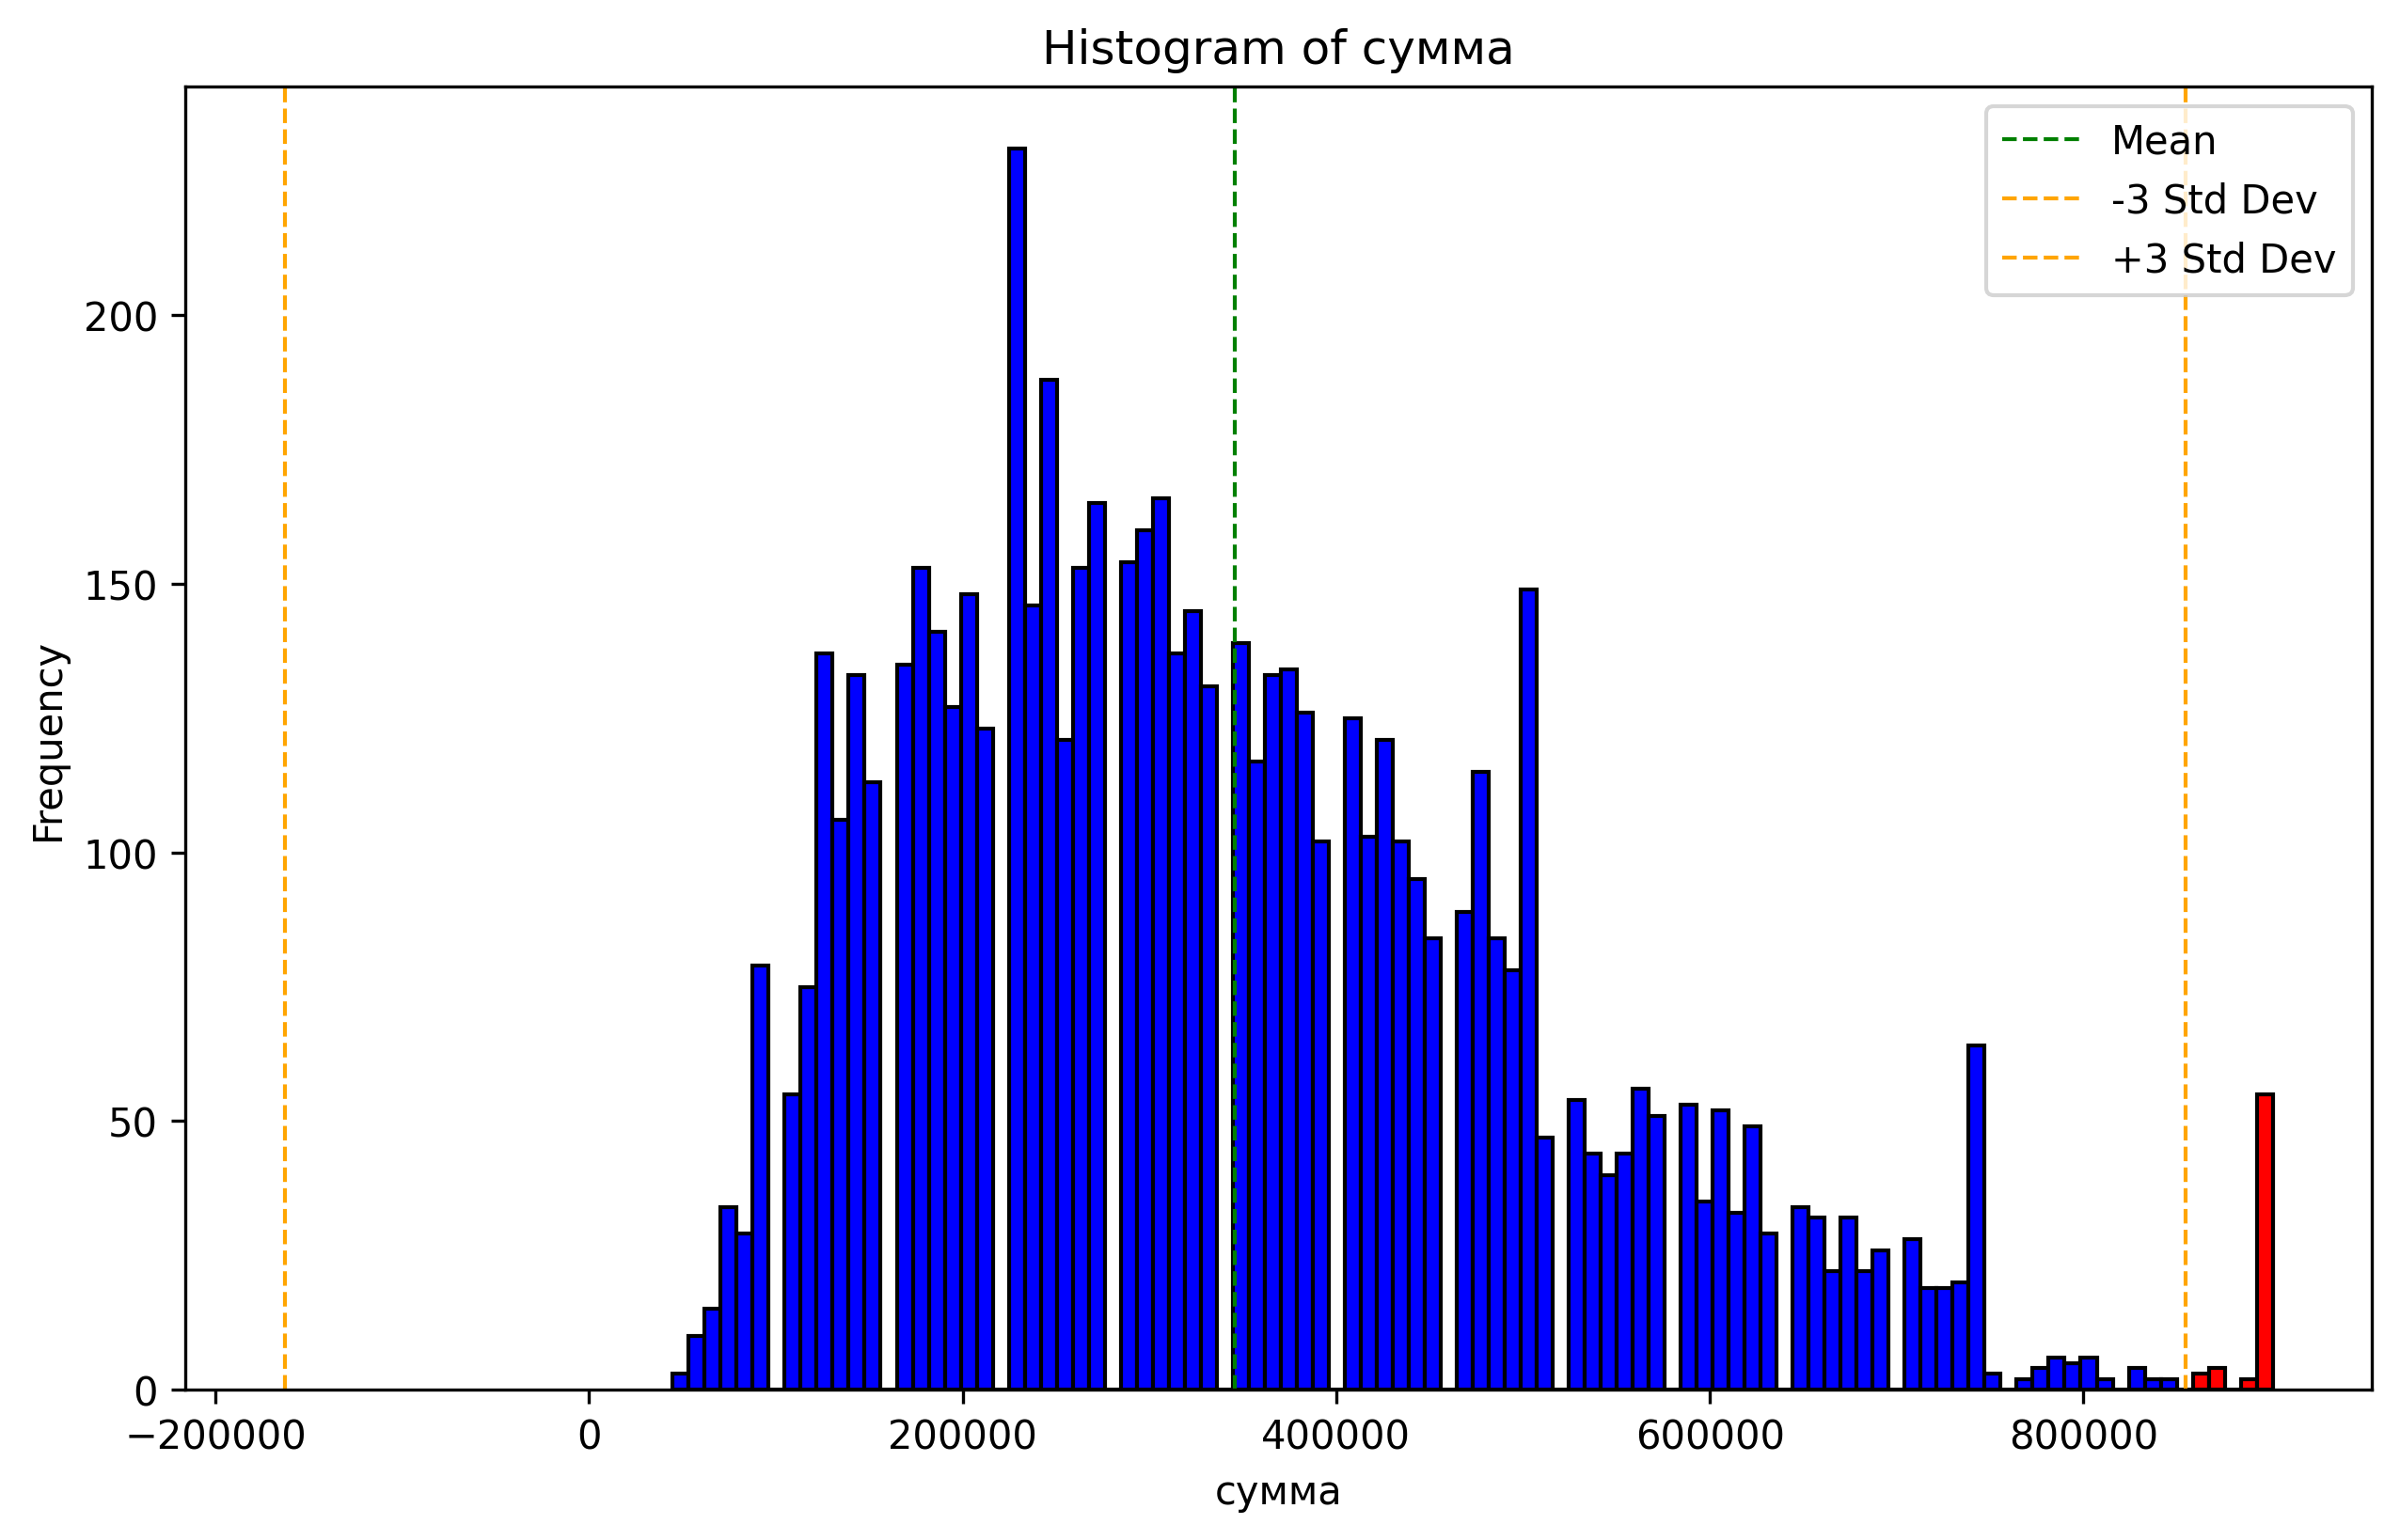

In [4]:
clipper_func = FunctionTransformer(
    transforms.clip_anomalies,
)
clipper = PandasTransformer(clipper_func, col_names=["сумма"])
pipe = make_pipeline(clipper)

vis.plot_anomalies(pipe.fit_transform(loan_data), ["сумма"])

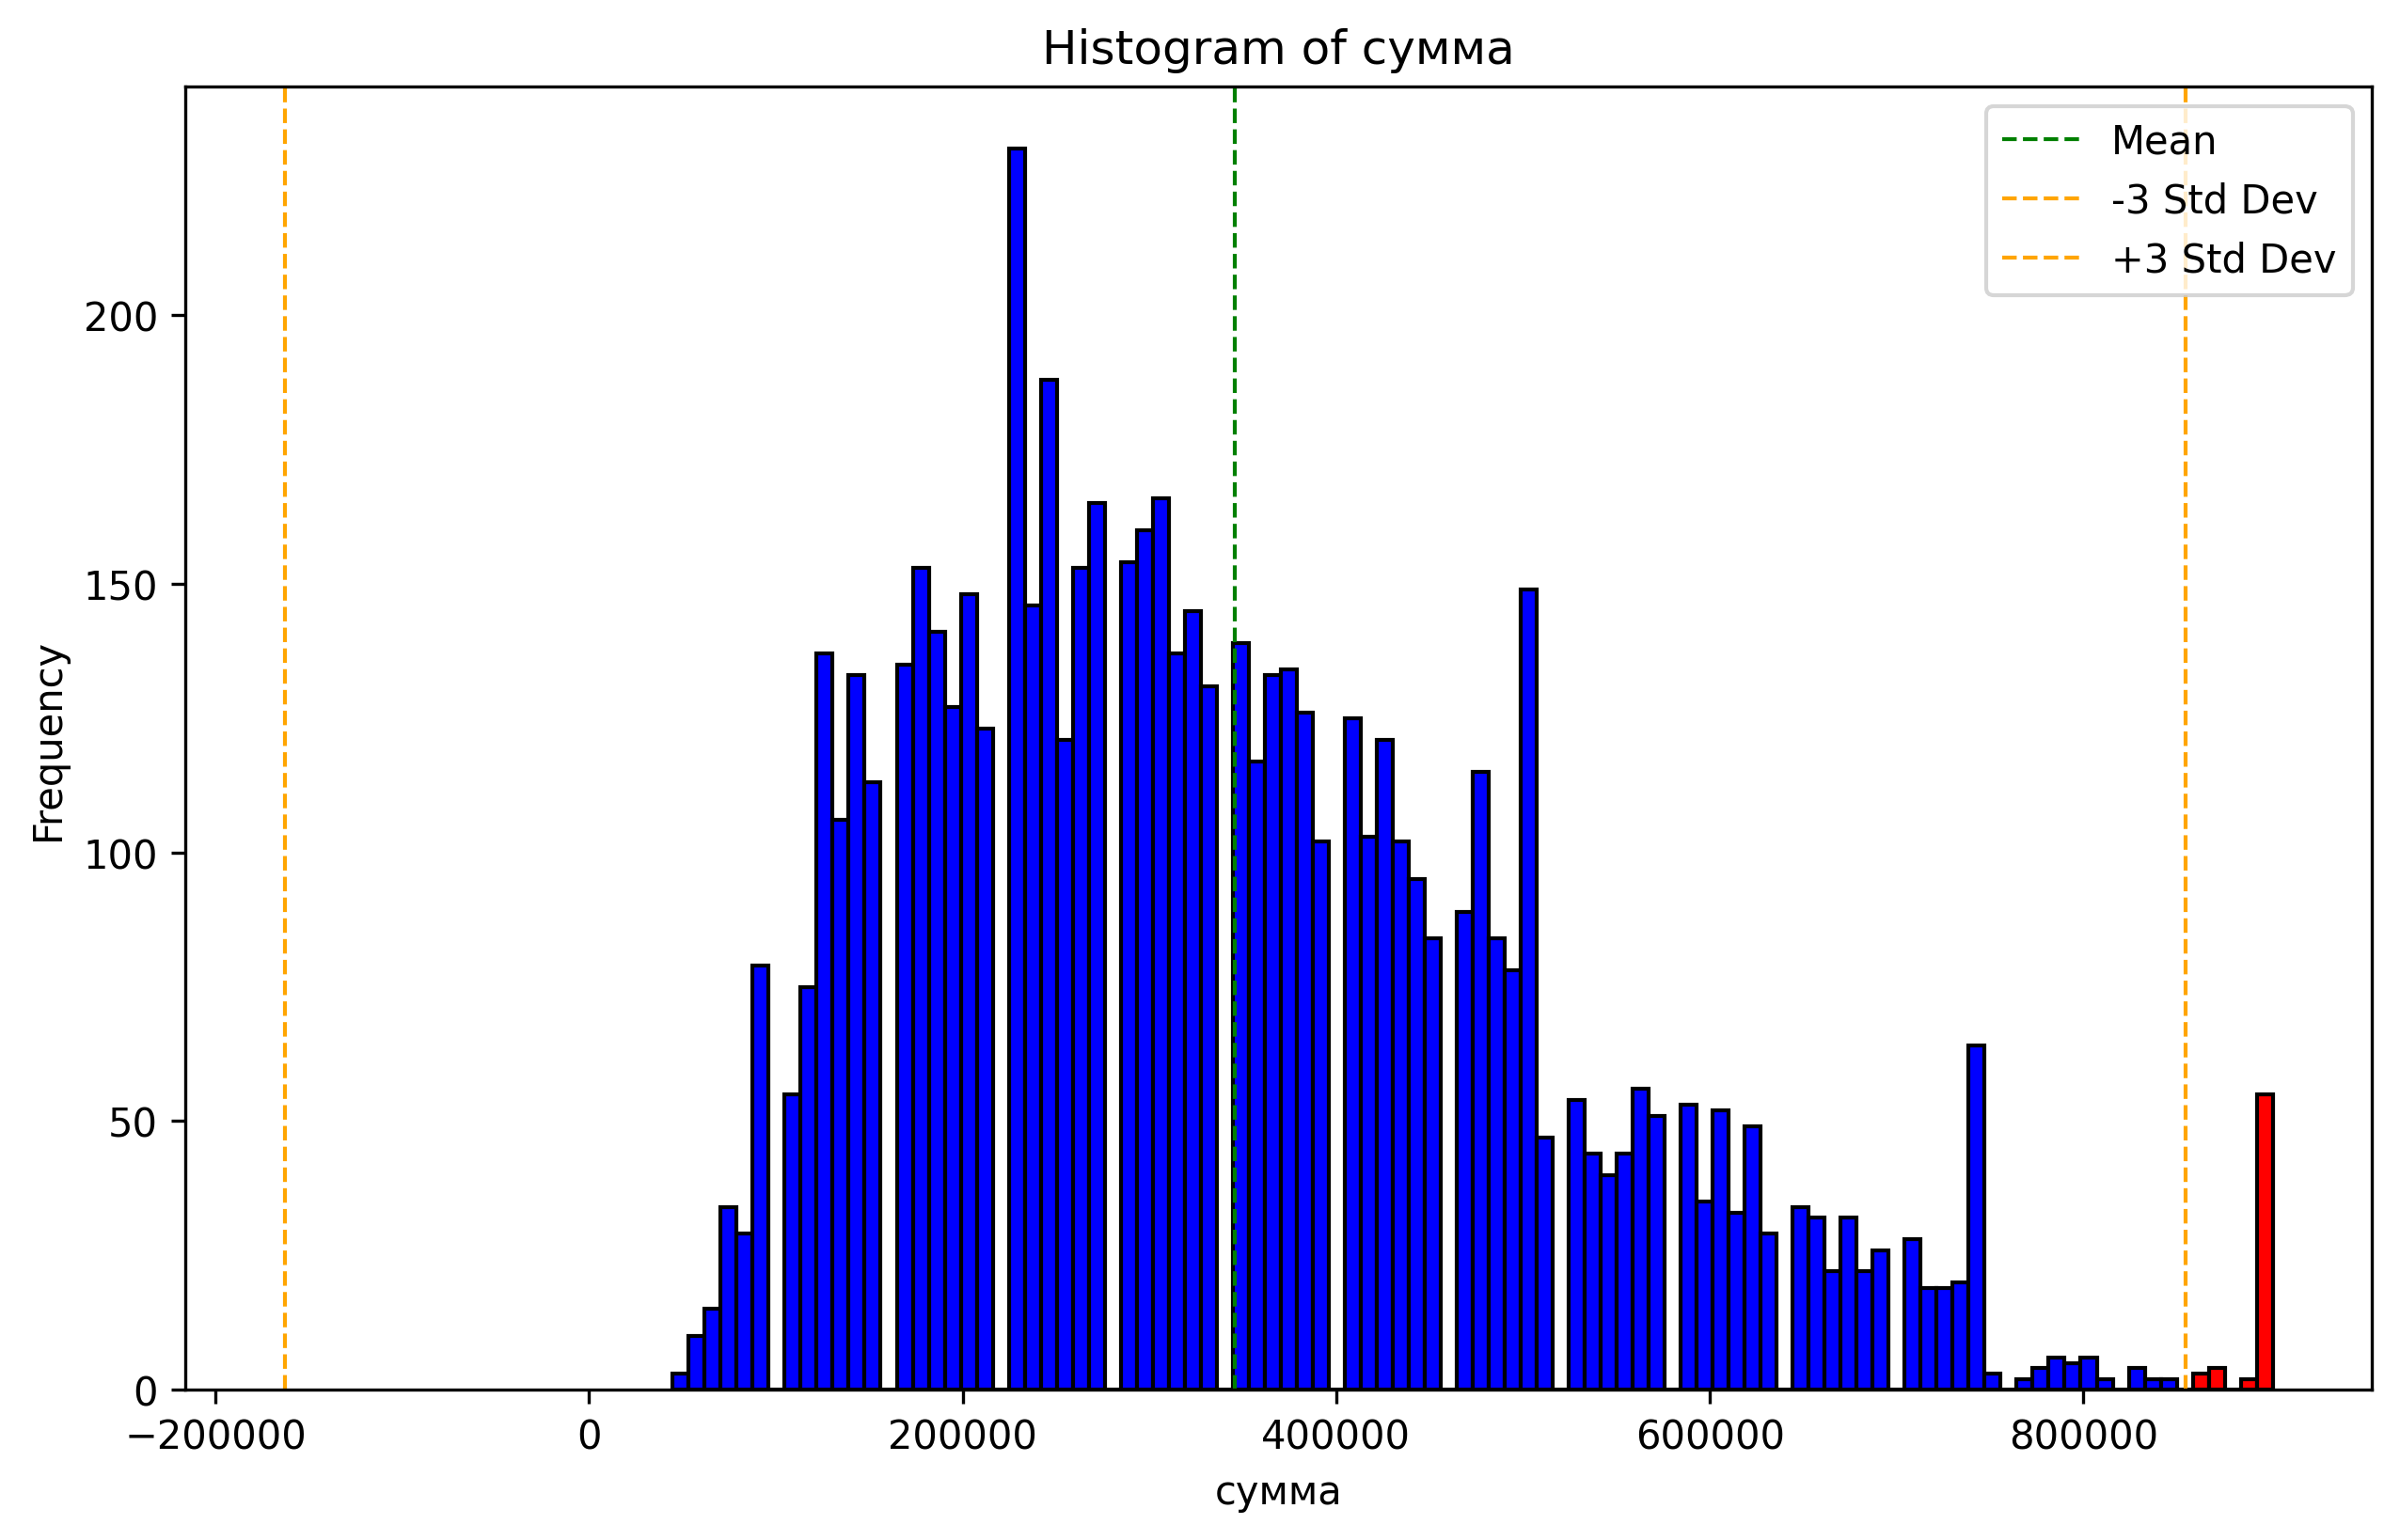

In [6]:
# Vis
cols = ["сумма"]
vis.plot_anomalies(transforms.clip_anomalies(loan_data[cols]), cols)

### Убрать аномальные значения

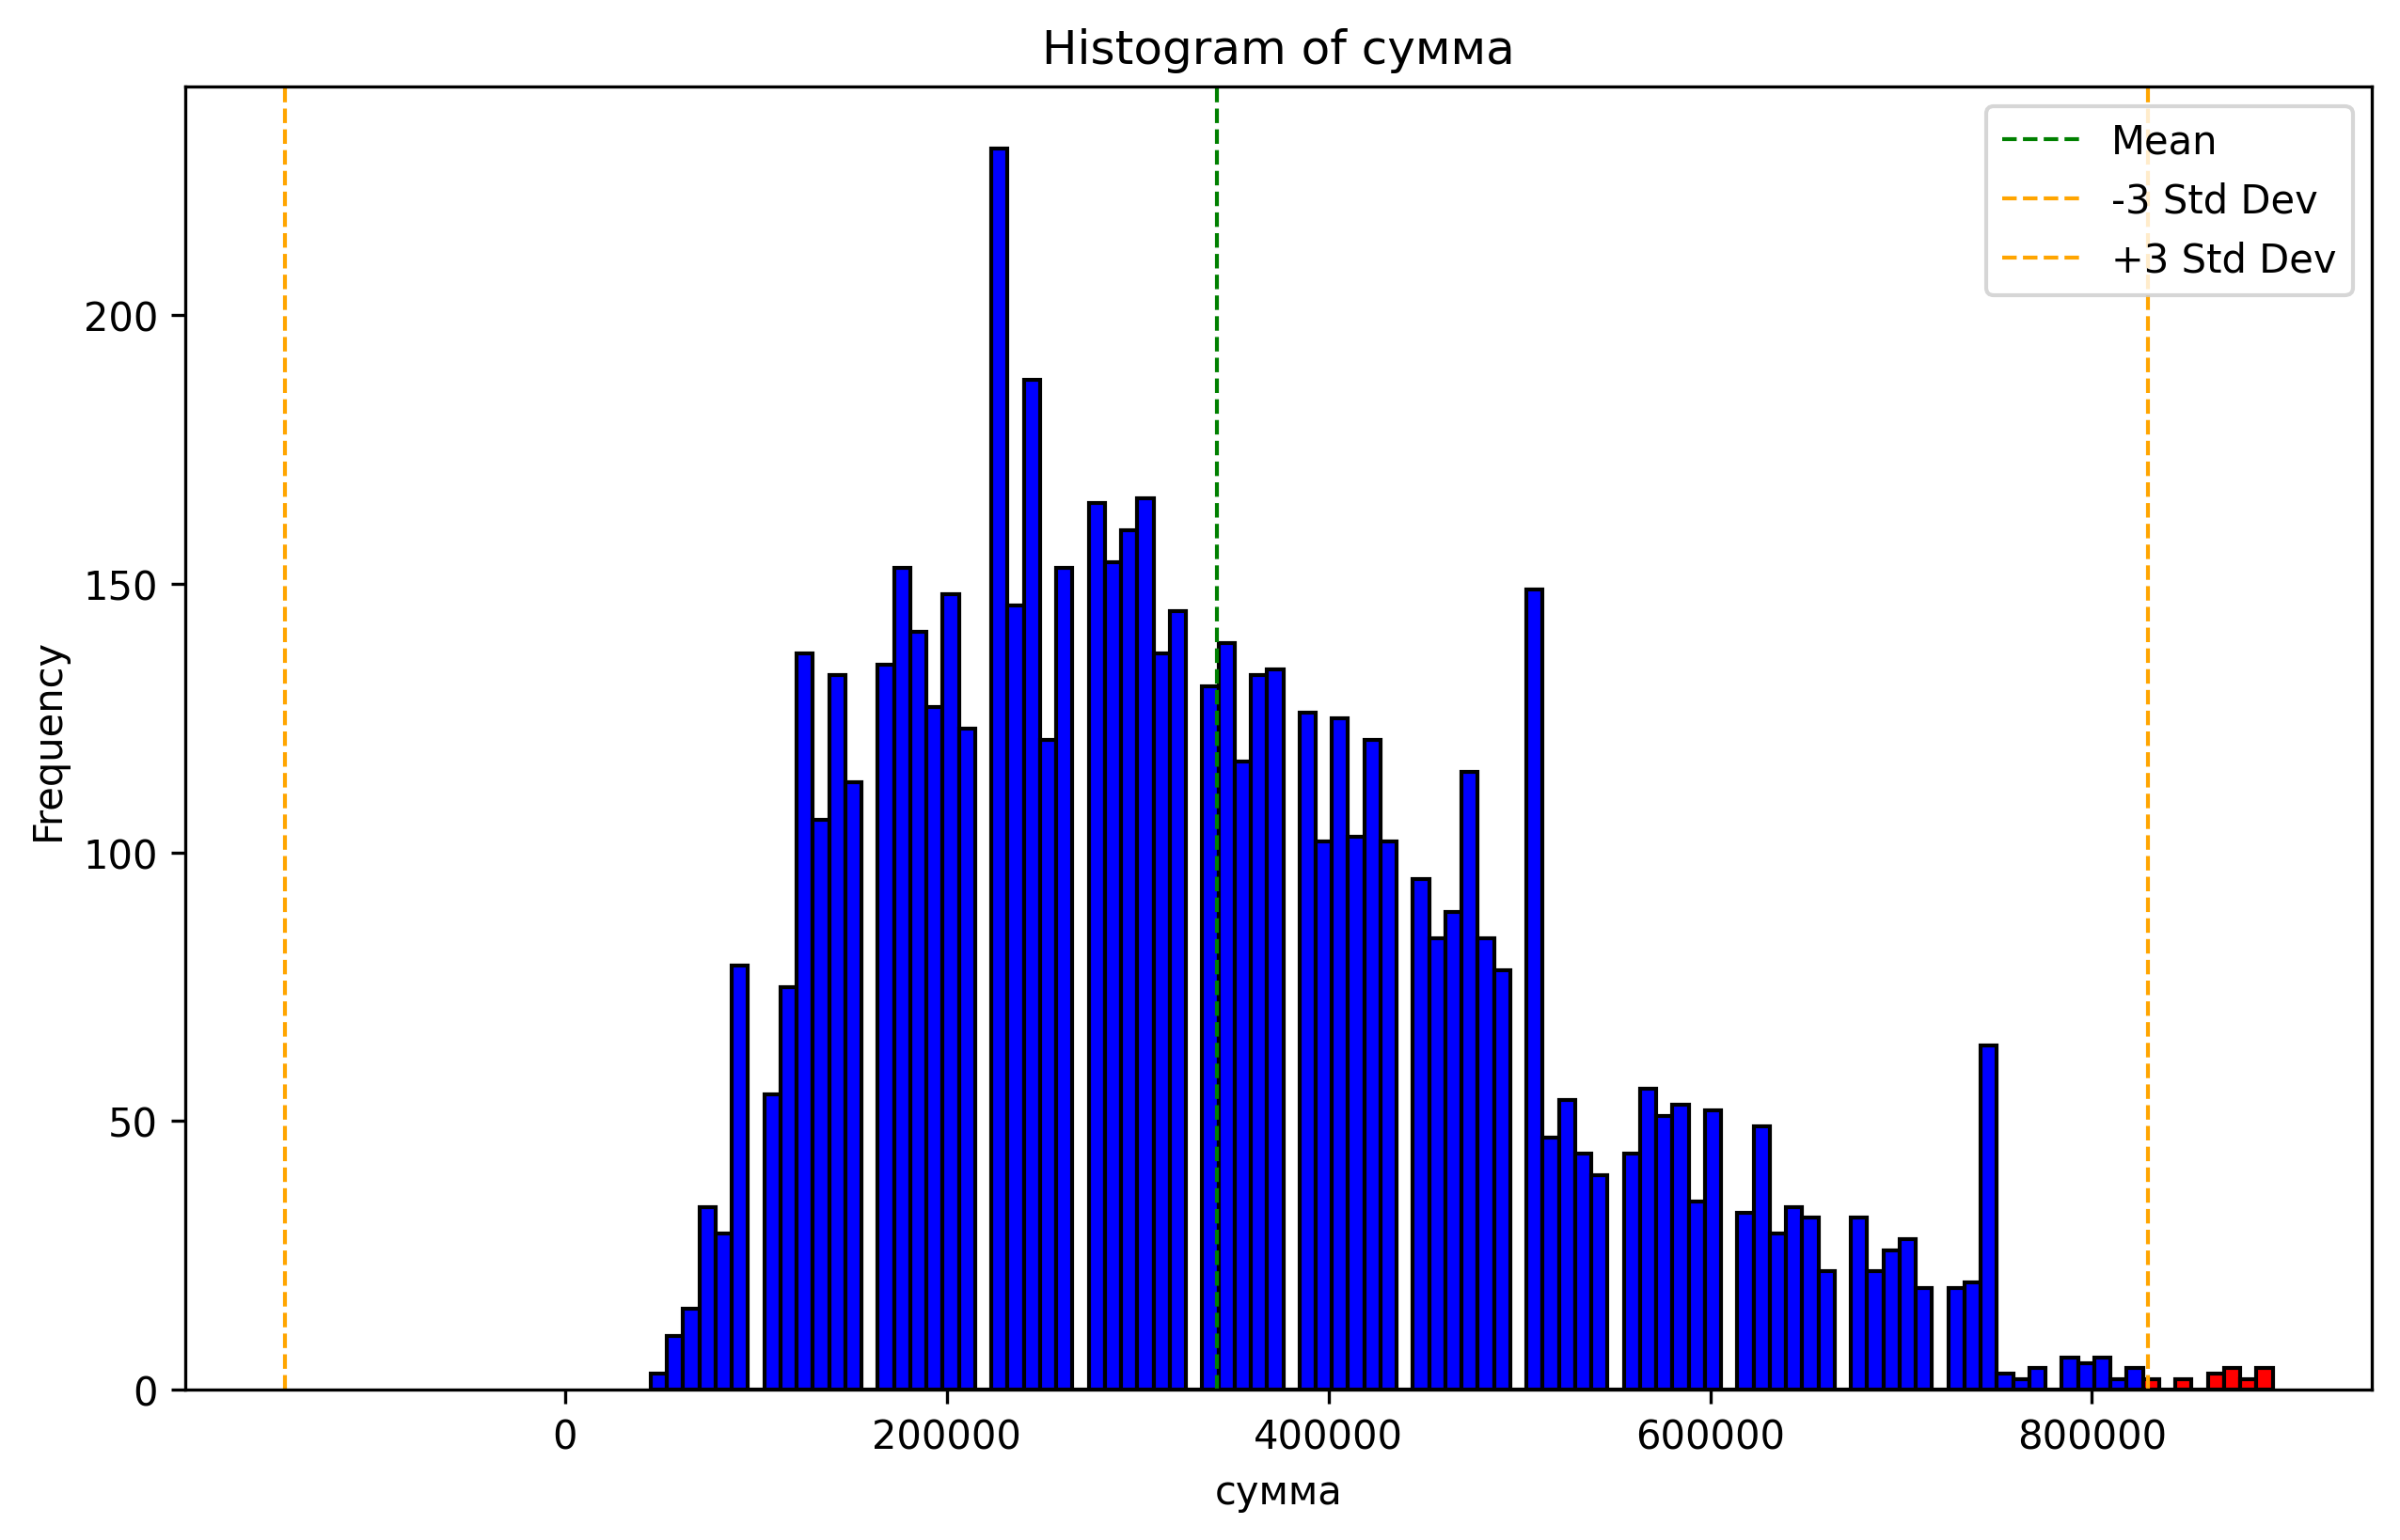

In [5]:
# В пайпе нельзя юзать

# Vis
cols = ["сумма"]
vis.plot_anomalies(transforms.remove_anomalies(loan_data[cols]), cols)

### Построить гистограммы

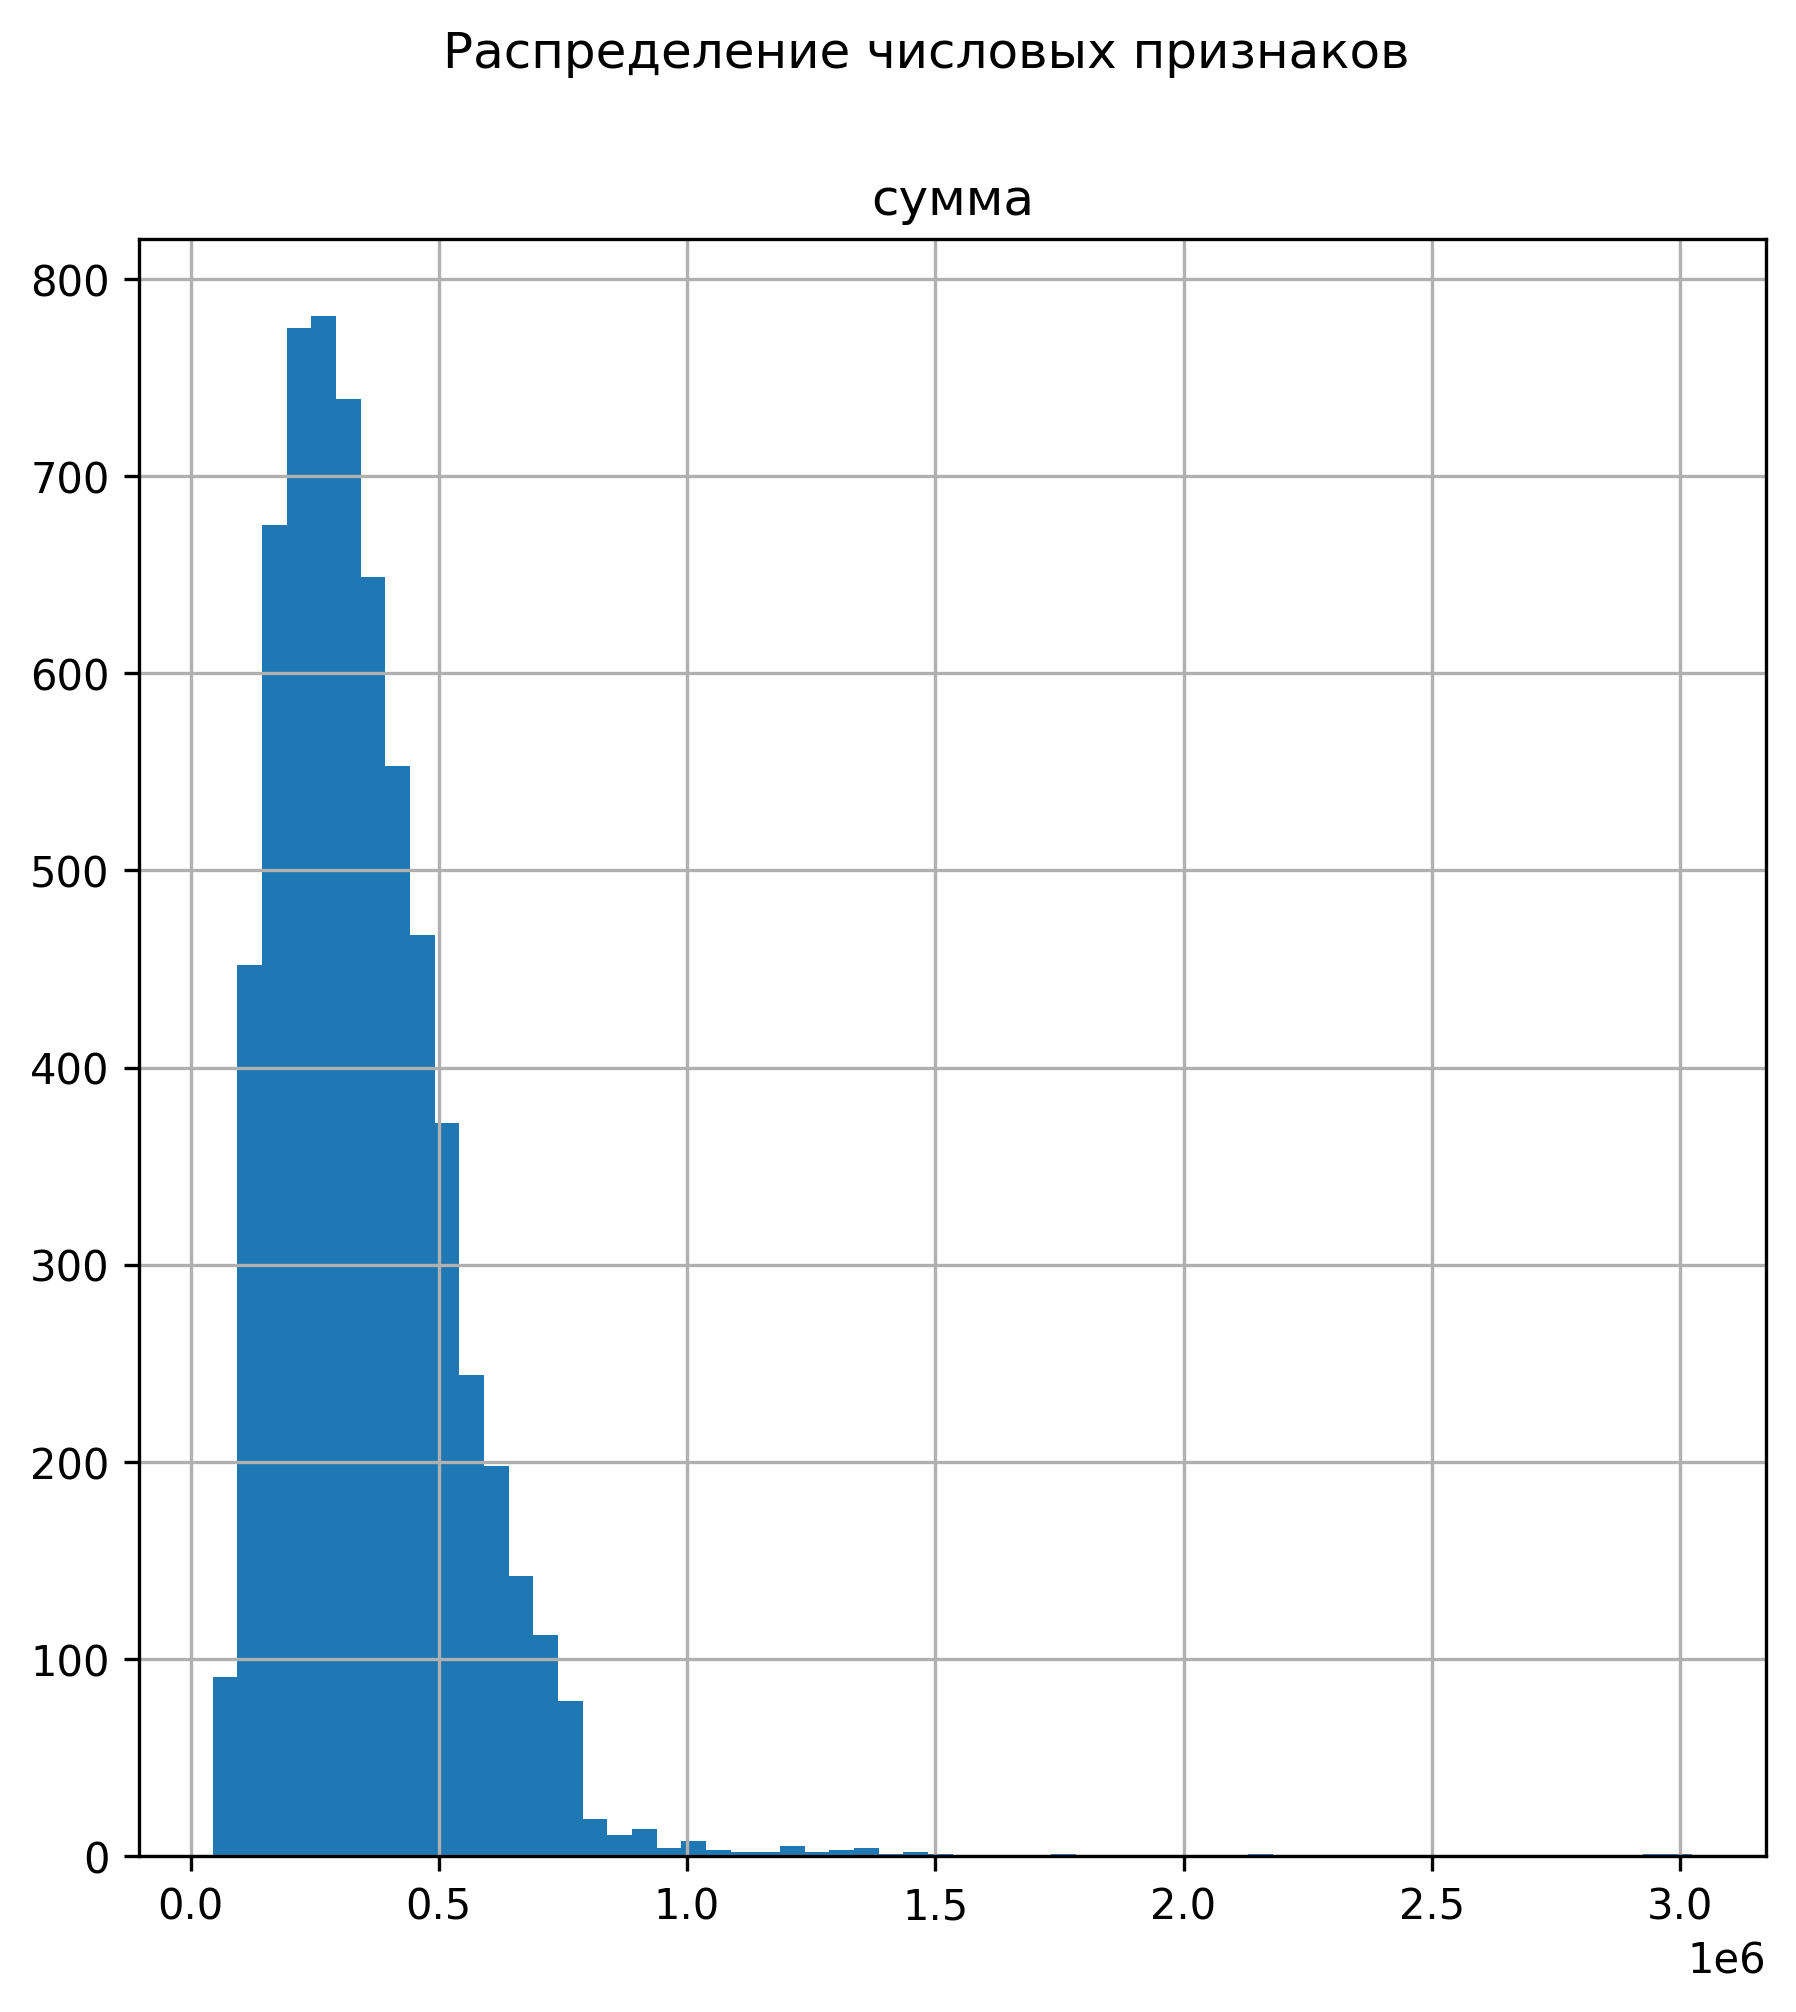

In [6]:
vis.plot_hist(loan_data, ["сумма"])

### Построить корреляционную матрицу

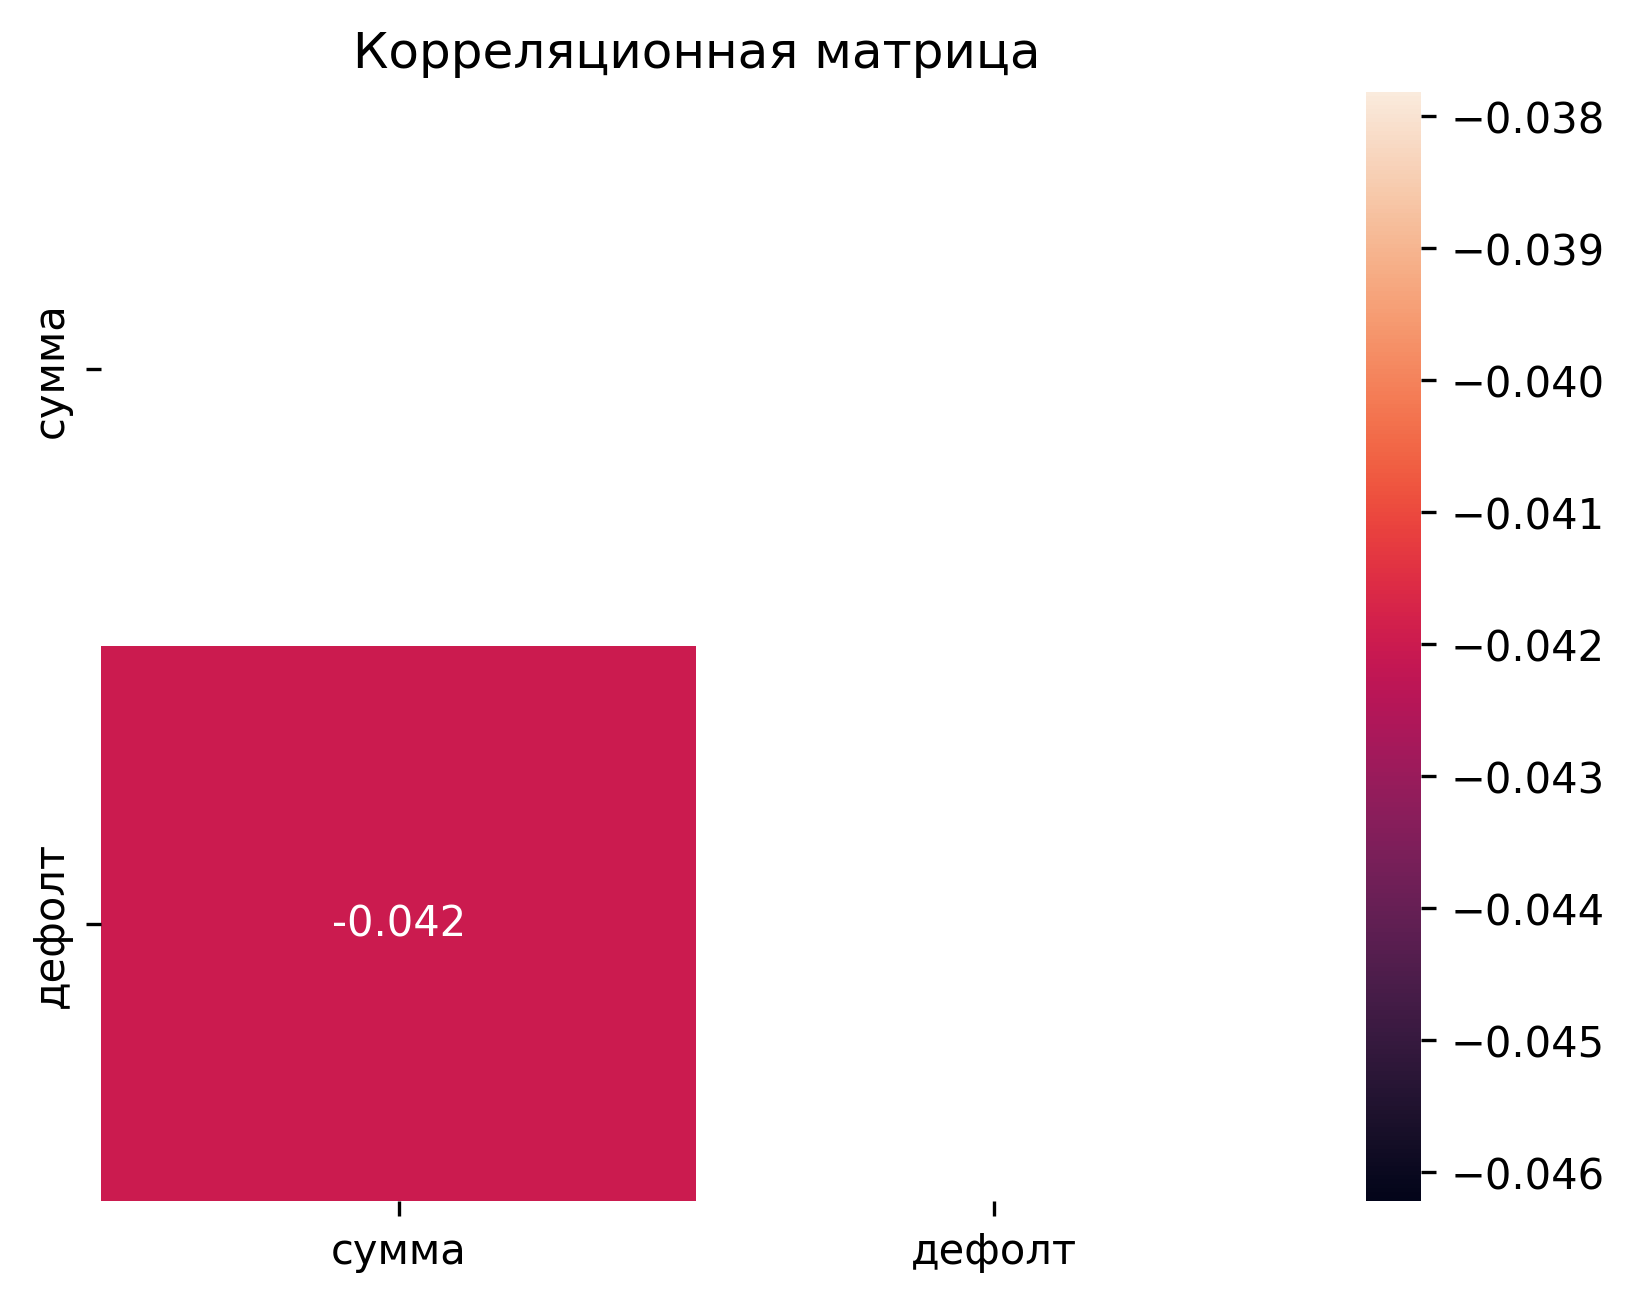

In [7]:
vis.plot_corr(loan_data, ["сумма", "дефолт"])

### Нормализовать числовые значения

In [8]:
scaler = StandardScaler()
scaler.fit_transform(loan_data[["сумма"]])

array([[-0.94245866],
       [        nan],
       [        nan],
       ...,
       [ 0.25137646],
       [ 1.33668111],
       [ 1.82506821]], shape=(8000, 1))

### Пропуски

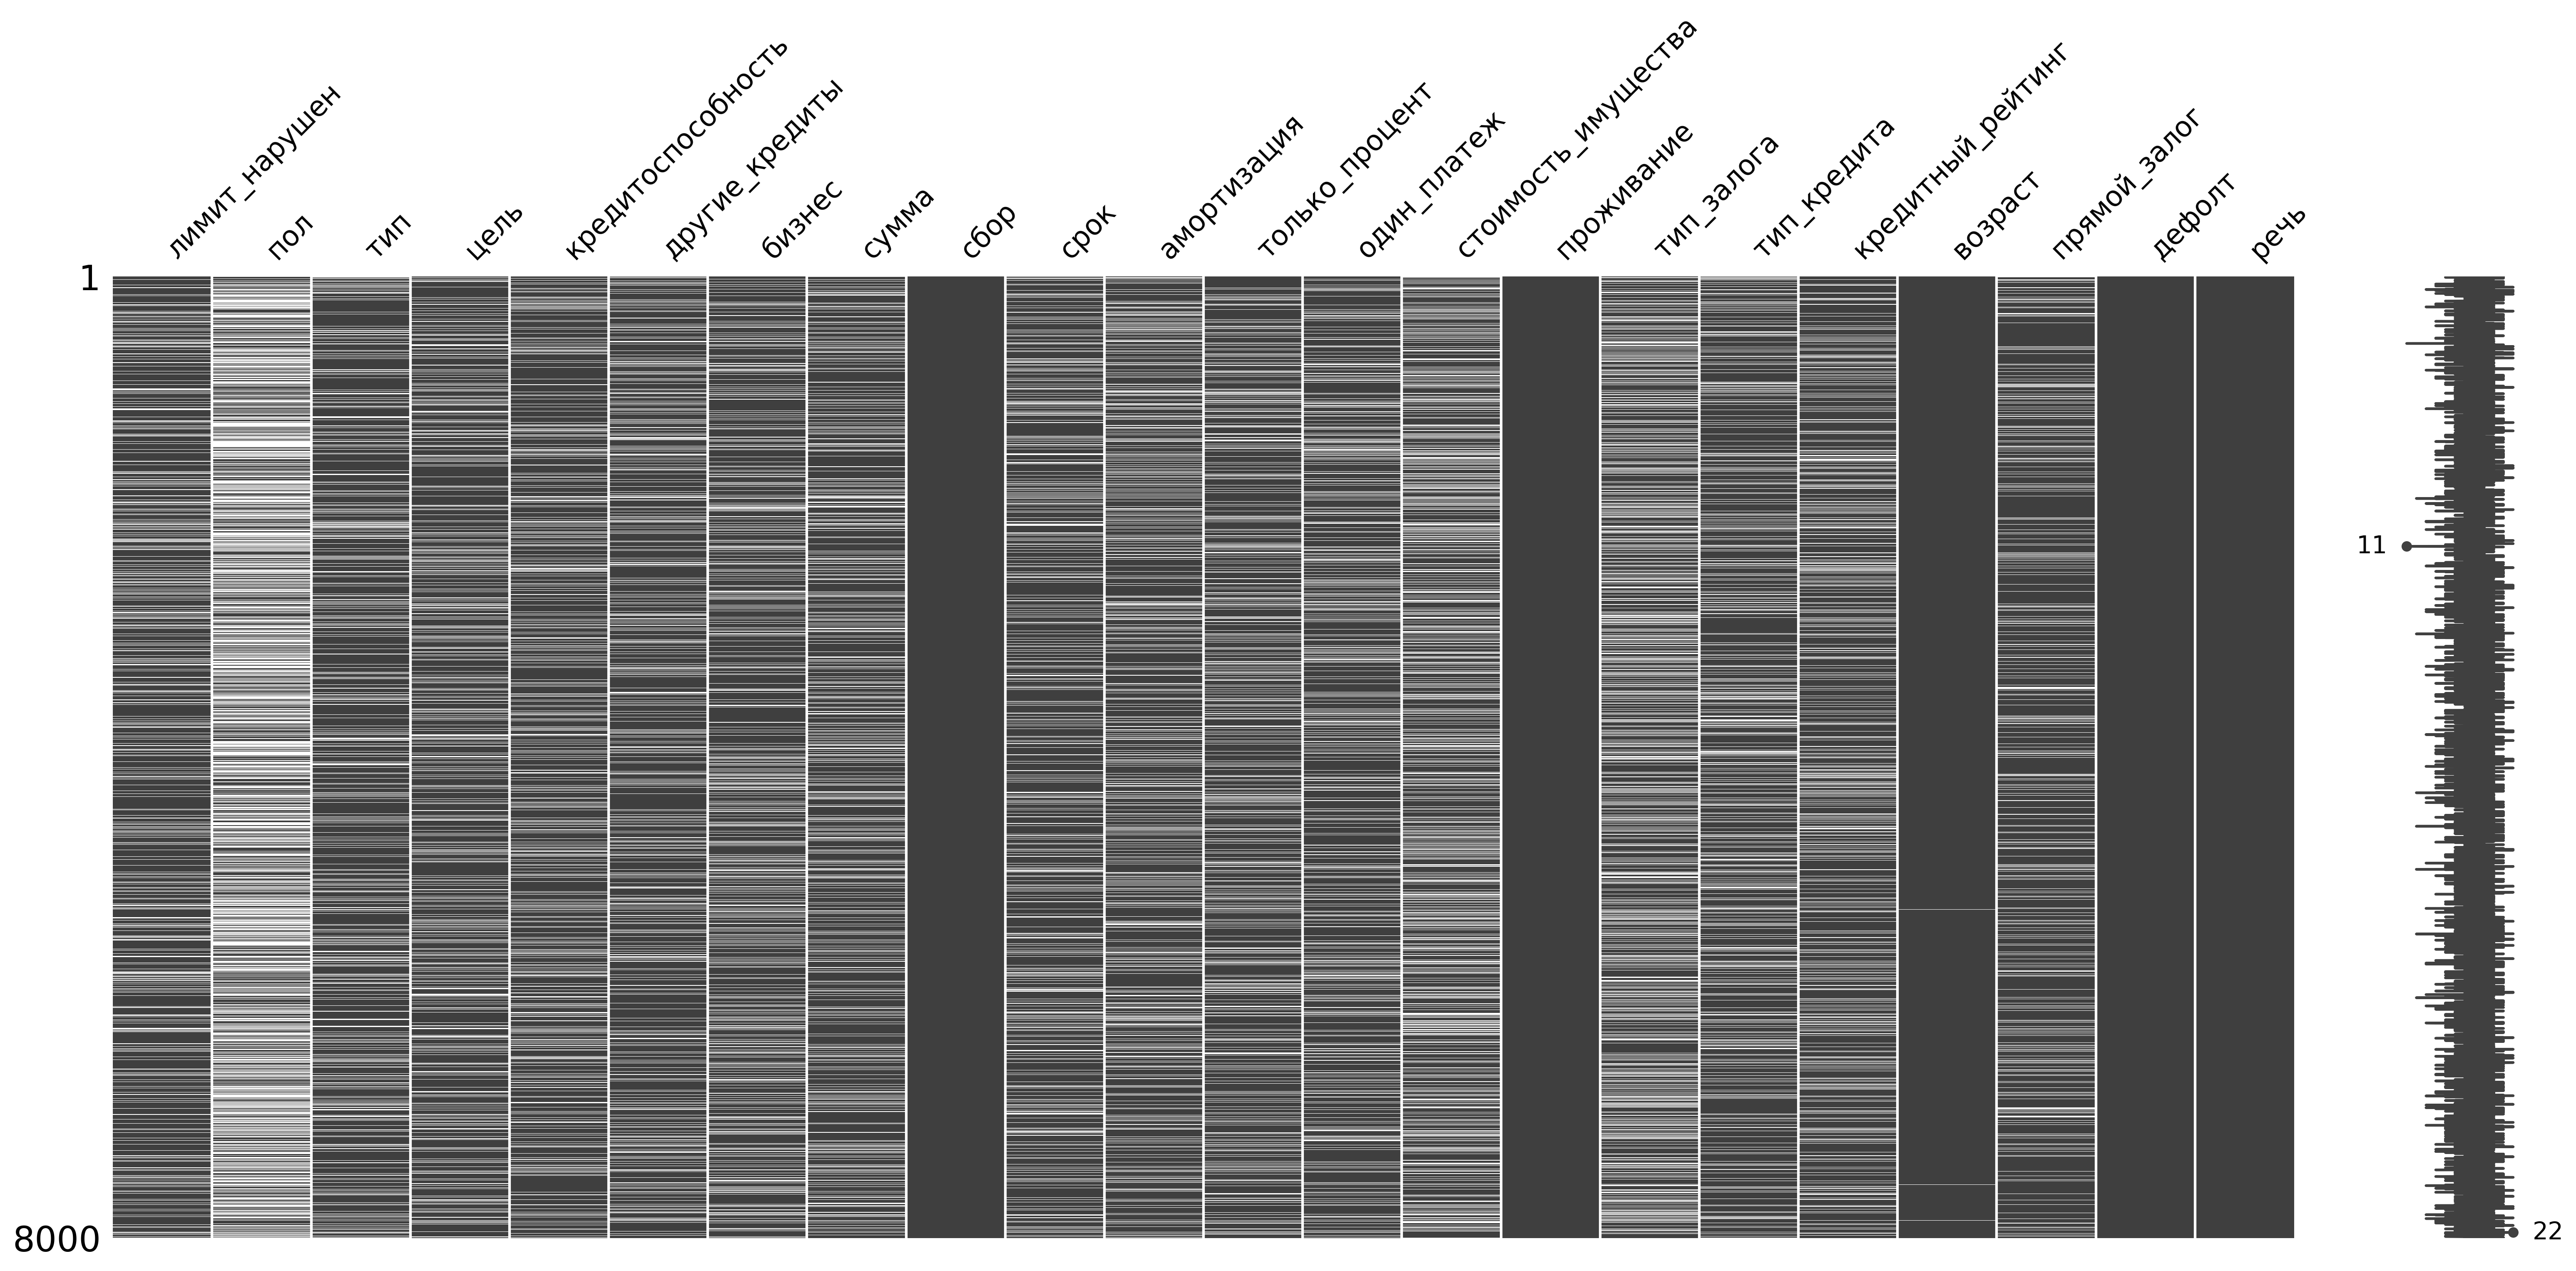

In [9]:
vis.plot_nan(loan_data)

### Заполнить пропуски

In [10]:
imputer = SimpleImputer(strategy="mean")
imputer.fit_transform(loan_data[["сумма"]])

array([[174765.26496798],
       [348441.59798949],
       [348441.59798949],
       ...,
       [394765.26496798],
       [594765.26496798],
       [684765.26496798]], shape=(8000, 1))

### Уникальные значения в категориальных столбцах

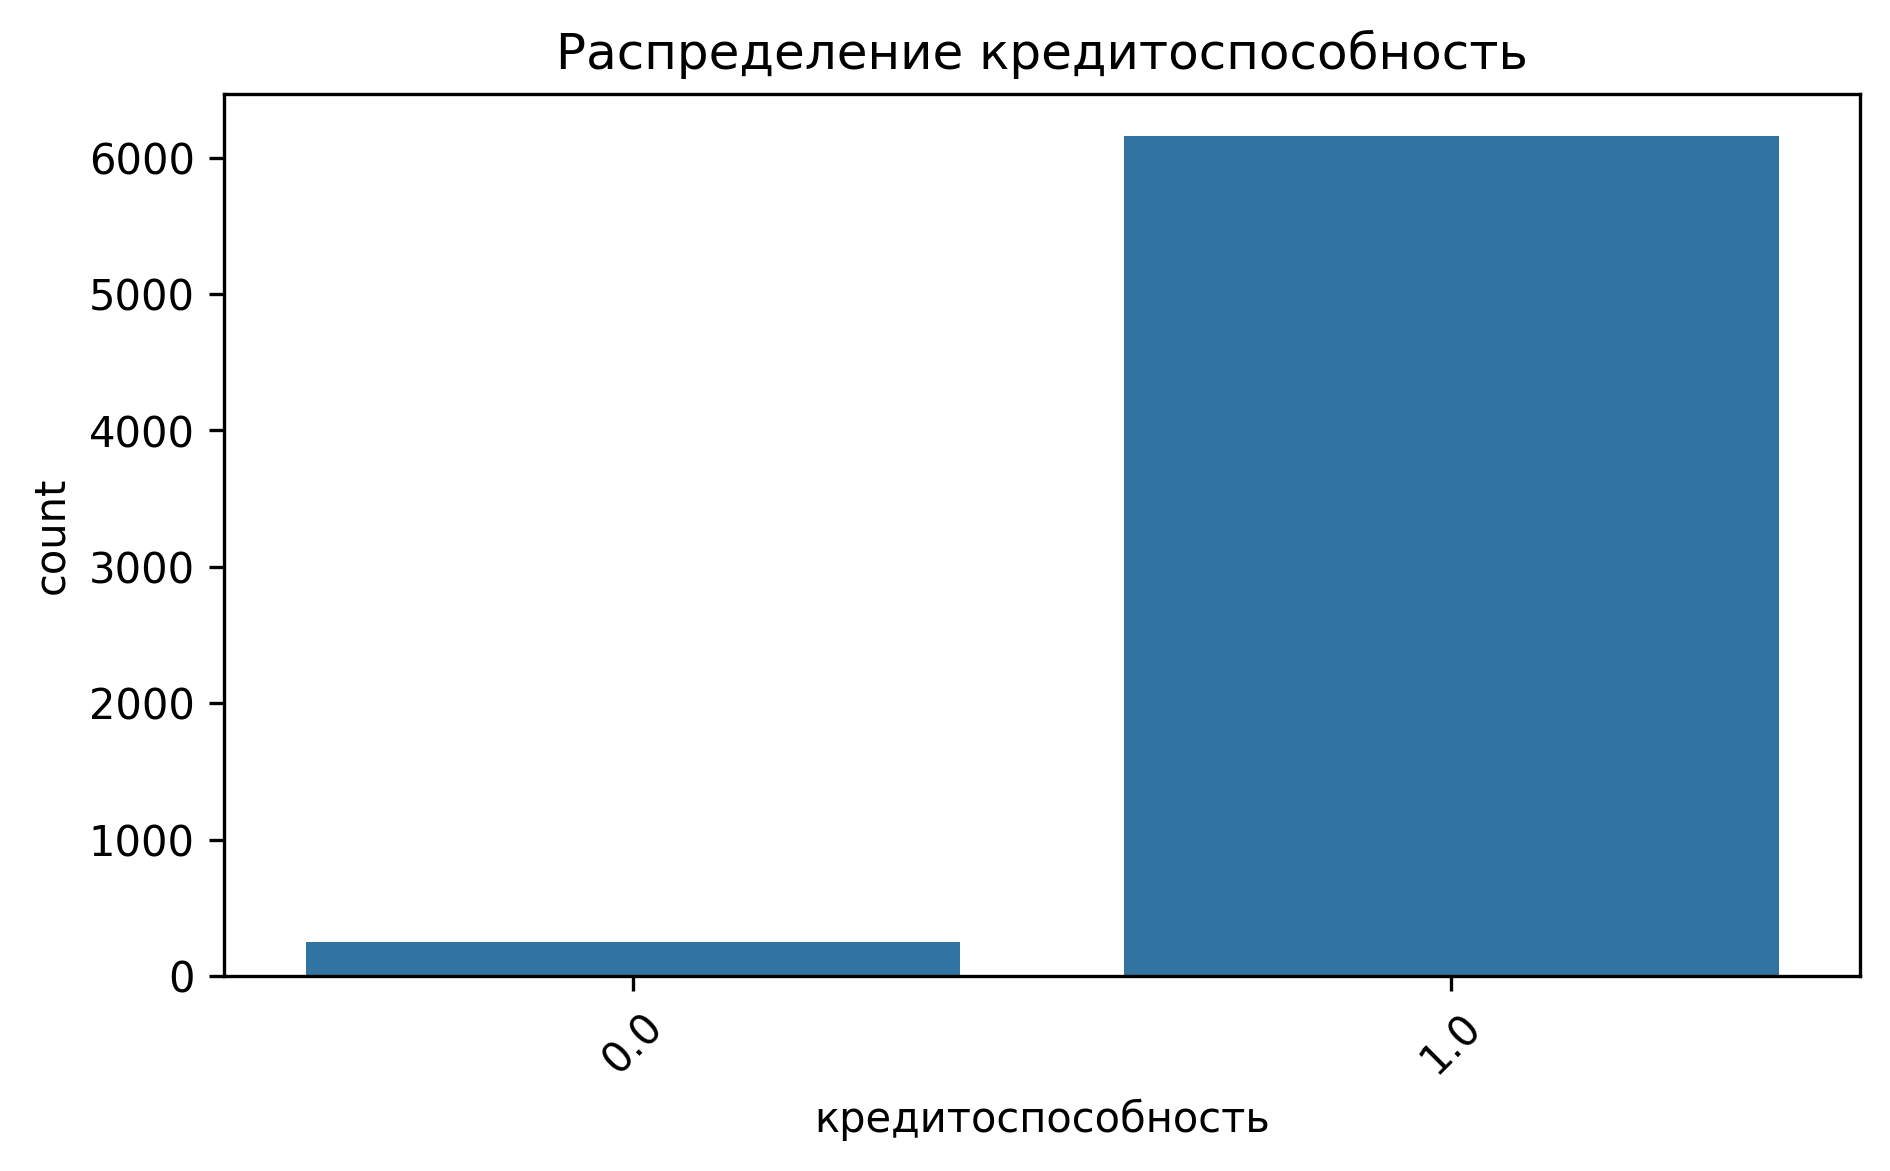

In [11]:
vis.plot_categorical_distributions(loan_data, ["кредитоспособность"])

In [12]:
vis.print_value_counts(loan_data, ["кредитоспособность"])

кредитоспособность
1.0    6157
0.0     249
Name: count, dtype: int64



### Заполнить пропуски в категориальных столбцах

In [13]:
cat_cols = ["кредитоспособность"]
pipe = PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols)
pipe.fit_transform(loan_data[cat_cols])

кредитоспособность
0                    1.0
1                    1.0
2                    1.0
3                    1.0
4                    1.0
...                  ...
7995                 1.0
7996                 1.0
7997                 1.0
7998                 1.0
7999                 1.0

[8000 rows x 1 columns]

### Закодировать категориальные признаки при помощи one hot encoding

In [ ]:
cat_cols = ["цель"]
pipe = OneHotEncoder(cat_cols)
pipe.fit_transform(loan_data, cat_cols)

лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  \
0               0.0    м  3.0   0.0                 1.0             NaN   
1               0.0  NaN  NaN   0.0                 1.0             0.0   
2               0.0    м  3.0   1.0                 1.0             0.0   
3               0.0  NaN  3.0   1.0                 1.0             0.0   
4               0.0  NaN  3.0   1.0                 NaN             0.0   
...             ...  ...  ...   ...                 ...             ...   
7995            0.0  NaN  3.0   1.0                 NaN             0.0   
7996            NaN  NaN  NaN   1.0                 1.0             0.0   
7997            0.0    м  3.0   3.0                 1.0             NaN   
7998            NaN  NaN  NaN   1.0                 1.0             0.0   
7999            0.0    ж  1.0   0.0                 1.0             0.0   

      бизнес          сумма                    сбор        срок  ...  \
0        0.0  174765.264968                  normal  245.885949  ...   
1        0.0            NaN                    want  365.885949  ...   
2        0.0            NaN                 regular  365.885949  ...   
3        0.0  474765.264968                  common  365.885949  ...   
4        0.0  384765.264968               excessive  365.885949  ...   
...      ...            ...                     ...         ...  ...   
7995     0.0            NaN              not slight  125.885949  ...   
7996     1.0            NaN                    mean  185.885949  ...   
7997     0.0  394765.264968     Whole lotta nothin'  365.885949  ...   
7998     0.0  594765.264968  Total lack of presence  365.885949  ...   
7999     0.0  684765.264968               minuscule  365.885949  ...   

      кредитный_рейтинг  возраст  прямой_залог  дефолт  \
0            709.508335    55-64           1.0       0   
1            722.508335    55-64           NaN       0   
2            785.508335    55-64           1.0       0   
3            594.508335    35-44           1.0       0   
4            589.508335    55-64           0.0       0   
...                 ...      ...           ...     ...   
7995                NaN    35-44           NaN       0   
7996         796.508335      >74           1.0       0   
7997         584.508335    25-34           1.0       1   
7998         873.508335    35-44           1.0       0   
7999                NaN    35-44           0.0       0   

                                                   речь цель_0.0  цель_1.0  \
0     "Hey there! I’m a guy with a solid job and a m...      1.0       0.0   
1     "Hi there! We are a couple with a solid financ...      1.0       0.0   
2     "I'm a male client with a modest income. I wor...      0.0       1.0   
3     "Hello, we’re a working couple enjoying the st...      0.0       1.0   
4     "Greetings, we're Chris and Sam. Both employed...      0.0       1.0   
...                                                 ...      ...       ...   
7995  "Hello! I’m here to introduce myself. I have a...      0.0       1.0   
7996  "Hello! I’m excited to be here. My income is m...      0.0       1.0   
7997  "I'm just an ordinary guy trying to make ends ...      0.0       0.0   
7998  "Hello! We’re a couple looking to manage our f...      0.0       1.0   
7999  "I'm a successful businesswoman with a dedicat...      1.0       0.0   

      цель_2.0 цель_3.0  цель_nan  
0          0.0      0.0       0.0  
1          0.0      0.0       0.0  
2          0.0      0.0       0.0  
3          0.0      0.0       0.0  
4          0.0      0.0       0.0  
...        ...      ...       ...  
7995       0.0      0.0       0.0  
7996       0.0      0.0       0.0  
7997       0.0      1.0       0.0  
7998       0.0      0.0       0.0  
7999       0.0      0.0       0.0  

[8000 rows x 27 columns]

### Закодировать категориальные признаки при помощи label encoding

In [8]:
cat_cols = ["пол"]
cat_encoder = ColumnTransformer(
    [("encoder", OrdinalEncoder(), cat_cols)],
    remainder="passthrough",
)
pipe = PandasTransformer(OrdinalEncoder(), cat_cols)
pipe.fit_transform(loan_data, cat_cols)[cat_cols]

пол
0     1.0
1     NaN
2     1.0
3     NaN
4     NaN
...   ...
7995  NaN
7996  NaN
7997  1.0
7998  NaN
7999  0.0

[8000 rows x 1 columns]

### Связь категориальных переменных и таргета

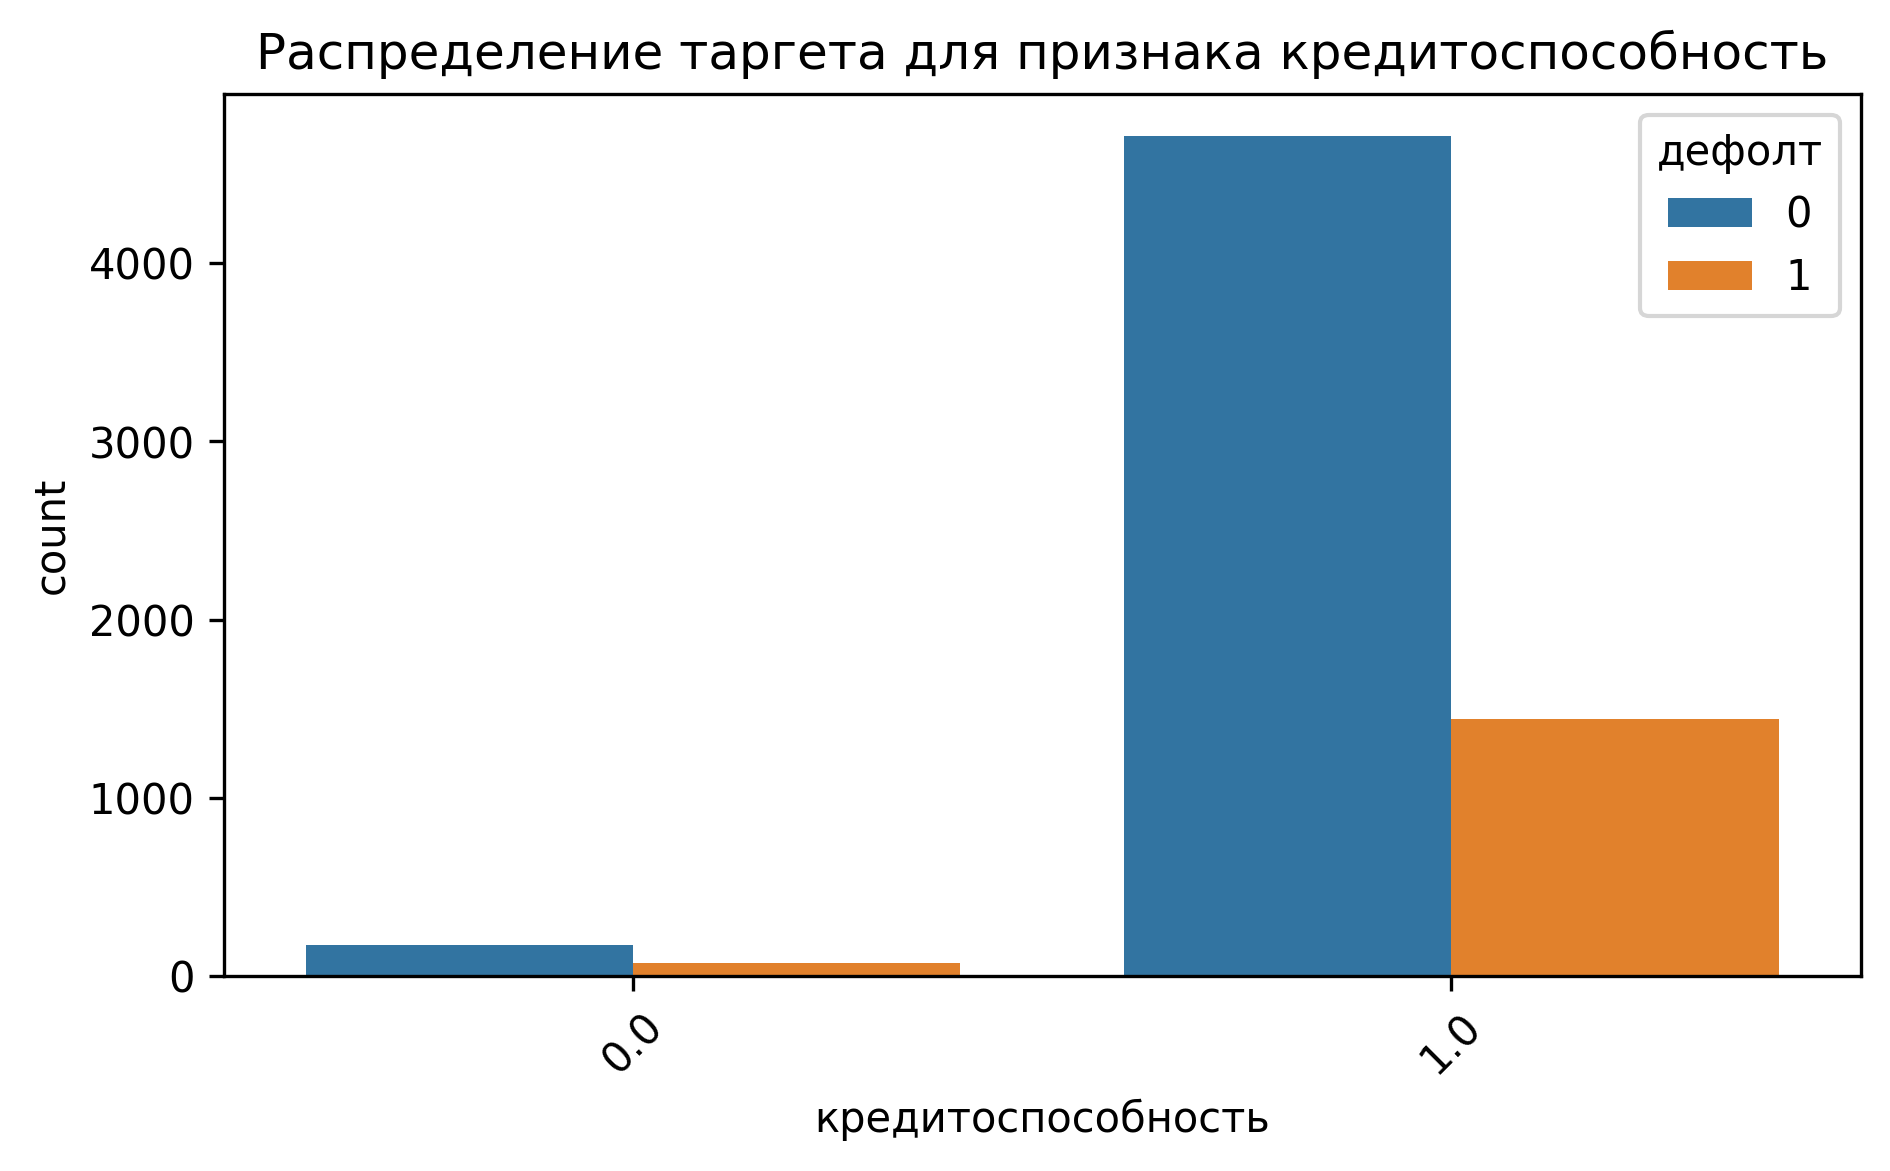

In [9]:
vis.visualize_cat_and_target(loan_data, ["кредитоспособность"])

# Модель

### Обучить модель без разделения

In [10]:
def train_log_reg(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    float_cols = X.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", transforms.FeatSelector(float_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    modeling.print_metrics(y_true=y, y_pred=pred)


train_log_reg(loan_data)

Accuracy: 0.812
Precision: 0.746
Recall: 0.315
f1: 0.443


/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Разделить выборку на обучающее и тестовое множество

In [11]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42)

### Сделать отчет о классификации

In [12]:
# Модифицируйте modeling.print_metrics

### Разделить выборку на обучающее и тестовое множество со стратификацией

In [13]:
# можно юзать и модифицировать modeling.get_train_test для удобства
df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42, stratify=loan_data[TARGET])

### Обучить модель с разделением

In [14]:
def train_model_with_test(data: pd.DataFrame) -> Pipeline:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    float_cols = list(X_train.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    pipe = make_pipeline(
        transforms.FeatSelector(float_cols + cat_cols),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
        PandasTransformer(OrdinalEncoder(), cat_cols),
        PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()
    return pipe


model = train_model_with_test(loan_data)
pred = model.predict(test_data)
pred_path = Path("output/pred.pkl")
pred_path.parent.mkdir(exist_ok=True)
joblib.dump(pred, pred_path)

Train
Accuracy: 0.815
Precision: 0.739
Recall: 0.300
f1: 0.426

Test
Accuracy: 0.798
Precision: 0.762
Recall: 0.285
f1: 0.415



/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['output/pred.pkl']

### Обучить модель с настройкой гиперпараметров

In [ ]:
def grid_search(data: pd.DataFrame) -> Pipeline:
    def get_model(float_cols: list[str], cat_cols: list[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(
            transforms.FeatSelector(float_cols + cat_cols),
            PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
            PandasTransformer(OrdinalEncoder(), cat_cols),
            PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
            RandomForestClassifier(random_state=42, **kwargs),
        )

    df_train, df_test = modeling.get_train_test(data)
    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)
    float_cols = list(X_train.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    params = {
        "bootstrap": [True, False],
        # "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "max_features": ["auto", "sqrt"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    for kwargs in tqdm(ParameterGrid(params)):
        cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
        cur_pipe.fit(X_train, y_train)
        pred = cur_pipe.predict(X_test)
        metric = f1_score(y_true=y_test, y_pred=pred)
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
    cur_pipe.fit(X_train, y_train)

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")
    return cast(Pipeline, pipe)


model = grid_search(loan_data)
pred = model.predict(test_data)
pred_path = Path("output/pred.pkl")
pred_path.parent.mkdir(exist_ok=True)
joblib.dump(pred, pred_path)

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Best metric: 0.538
Best kwargs: {'bootstrap': False}


['output/model.pkl']

### Обучить модель с настройкой гиперпараметров на кросс вале

In [ ]:
def grid_search_cv(data: pd.DataFrame) -> Pipeline:
    X, y = modeling.get_xy(data)
    float_cols = list(X.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]

    params = {
        "randomforestclassifier__bootstrap": [True, False],
        # "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # "randomforestclassifier__max_features": ["auto", "sqrt"],
        # "randomforestclassifier__min_samples_leaf": [1, 2, 4],
        # "randomforestclassifier__min_samples_split": [2, 5, 10],
        # "randomforestclassifier__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    }

    model = make_pipeline(
        transforms.FeatSelector(float_cols + cat_cols),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
        PandasTransformer(OrdinalEncoder(), cat_cols),
        PandasTransformer(SimpleImputer(strategy="most_frequent"), cat_cols),
        RandomForestClassifier(random_state=42),
    )
    pipe = GridSearchCV(model, param_grid=params)
    pipe.fit(X, y)
    print("Best params:", pipe.best_params_)
    print("Best score:", pipe.best_score_)
    return cast(Pipeline, pipe)


model = grid_search_cv(loan_data)
pred = model.predict(test_data)
pred_path = Path("output/pred.pkl")
pred_path.parent.mkdir(exist_ok=True)
joblib.dump(pred, pred_path)

Best params: {'randomforestclassifier__bootstrap': True}
Best score: 0.8408749999999999


['output/model.pkl']

### Обучить модель с настройкой гиперпараметров на кросс вале (для кастомной метрики)

In [52]:
from sklearn.metrics import roc_auc_score


def less_than_min(a: np.ndarray) -> float:
    return a[~np.isnan(a)].min() - 1000


def grid_search_cv_custom(data: pd.DataFrame, n_splits: int = 3) -> Pipeline:
    def get_model(float_cols: list[str], cat_cols: list[str], **kwargs: Any) -> Pipeline:
        return make_pipeline(
            transforms.FeatSelector(float_cols + cat_cols),
            PandasTransformer(SimpleImputer(strategy="constant", fill_value=0), float_cols),
            PandasTransformer(OrdinalEncoder(), cat_cols),
            PandasTransformer(SimpleImputer(strategy=less_than_min), cat_cols),
            RandomForestClassifier(random_state=42, n_jobs=5, **kwargs),
        )

    # data_mask = (data["прямой_залог"] != 1) | (data["стоимость_имущества"].fillna(0) <= 0)
    # data = data[data_mask].reset_index(drop=True)
    X, y = modeling.get_xy(data)
    float_cols = list(X.select_dtypes(exclude=object).columns)
    cat_cols = ["пол"]
    params = {
        # "max_depth": [10, 30, 60, 80, None],
        "max_features": ["sqrt", "log2"],
        # "min_samples_leaf": [1, 2, 4],
        # "min_samples_split": [2, 5, 10],
        # "n_estimators": [200, 500, 1000, 2000],
    }

    best_metric = -np.inf
    best_kwargs: dict[str, Any] | None = None

    folds = list(KFold(n_splits=n_splits).split(X))

    for kwargs in tqdm(ParameterGrid(params)):
        fold_metrics: list[float] = []

        for train_i, test_i in folds:
            X_train, y_train = X.loc[train_i], y.loc[train_i]
            X_test, y_test = X.loc[test_i], y.loc[test_i]

            cur_pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **kwargs)
            cur_pipe.fit(X_train, y_train)
            pred = cur_pipe.predict_proba(X_test)[:, 1]
            cur_metric = roc_auc_score(y_true=y_test, y_score=pred)
            fold_metrics.append(cur_metric)

        metric = float(np.mean(fold_metrics))
        if metric > best_metric:
            best_metric = metric
            best_kwargs = kwargs

    assert best_kwargs is not None
    pipe = get_model(float_cols=float_cols, cat_cols=cat_cols, **best_kwargs)
    pipe.fit(X, y)

    print(f"Best metric: {best_metric:.3f}")
    print(f"Best kwargs: {best_kwargs}")
    return pipe


model = grid_search_cv_custom(loan_data)

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

Best metric: 0.773
Best kwargs: {'max_features': 'sqrt'}


In [57]:
THRESH = 0.5
pred = model.predict_proba(test_data)[:, 1] >= THRESH
pred[(test_data["прямой_залог"] == 1) & (test_data["стоимость_имущества"].fillna(0) > 0)] = 0
pred_path = Path("output/pred.pkl")
pred_path.parent.mkdir(exist_ok=True)
joblib.dump(pred, pred_path)

['output/pred.pkl']

### Разработка текстовых фич

In [23]:
nltk.download("punkt_tab")


def train_text(data: pd.DataFrame) -> None:
    df_train, df_test = modeling.get_train_test(data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    cols = list(X_train.select_dtypes(exclude=object).columns)
    cols.append("речь")

    pipe = make_pipeline(
        transforms.FeatSelector(cols),
        transforms.TextFeaturesExtractor(text_feat="речь"),
        SimpleImputer(strategy="mean"),
        StandardScaler(),
        LogisticRegression(random_state=42),
    )
    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()


train_text(loan_data)

[nltk_data] Downloading package punkt_tab to /Users/user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Train
Accuracy: 0.846
Precision: 0.827
Recall: 0.416
f1: 0.553

Test
Accuracy: 0.823
Precision: 0.799
Recall: 0.396
f1: 0.529



# Бизнес

### Спроектировать бизнес-метрику для модели

In [ ]:
# Наша реализация - business.profit